In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sns
import socket
import os
from preproc_funcs import *
%load_ext autoreload
%autoreload 1
%matplotlib inline

In [2]:
subjID = 1
day = 2
p = {}
hostname = socket.gethostname()
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datc'] =  '/d/DATC/datc/MD_TMS_EEG'
else:
    p['datc'] =  '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datc/MD_TMS_EEG'
p['data'] = p['datc'] + '/data'
p['analysis'] = p['datc'] + '/analysis'
p['meta'] = p['datc'] + '/analysis/meta_analysis'
p['EEGData'] = f"{p['datc']}/EEGData/sub{subjID:02d}/day{day:02d}"
p['EEGpy'] = f"{p['datc']}/EEGpy/sub{subjID:02d}/day{day:02d}"

if not os.path.exists(p['EEGpy']):
    os.makedirs(p['EEGpy'])
p['general'] = f"{p['EEGpy']}/sub{subjID:02d}_day{day:02d}"
p['concat'] = f"{p['general']}.vhdr"

In [4]:
raw_data = mne.io.read_raw_brainvision(p['concat'], preload=True)
raw_data.drop_channels(['LM', 'RM'])
montage = mne.channels.make_standard_montage("easycap-M1")
raw_data.set_montage(montage)
raw_data.filter(0.1, 50)

Extracting parameters from /Users/mrugankdake/Documents/Clayspace/EEG_TMS/datc/MD_TMS_EEG/EEGpy/sub05/day01/sub05_day01.vhdr...
Setting channel info structure...
Reading 0 ... 3829179  =      0.000 ...  3829.179 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    5.2s finished


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,66 points
Good channels,63 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,50.00 Hz


Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 102.1s.


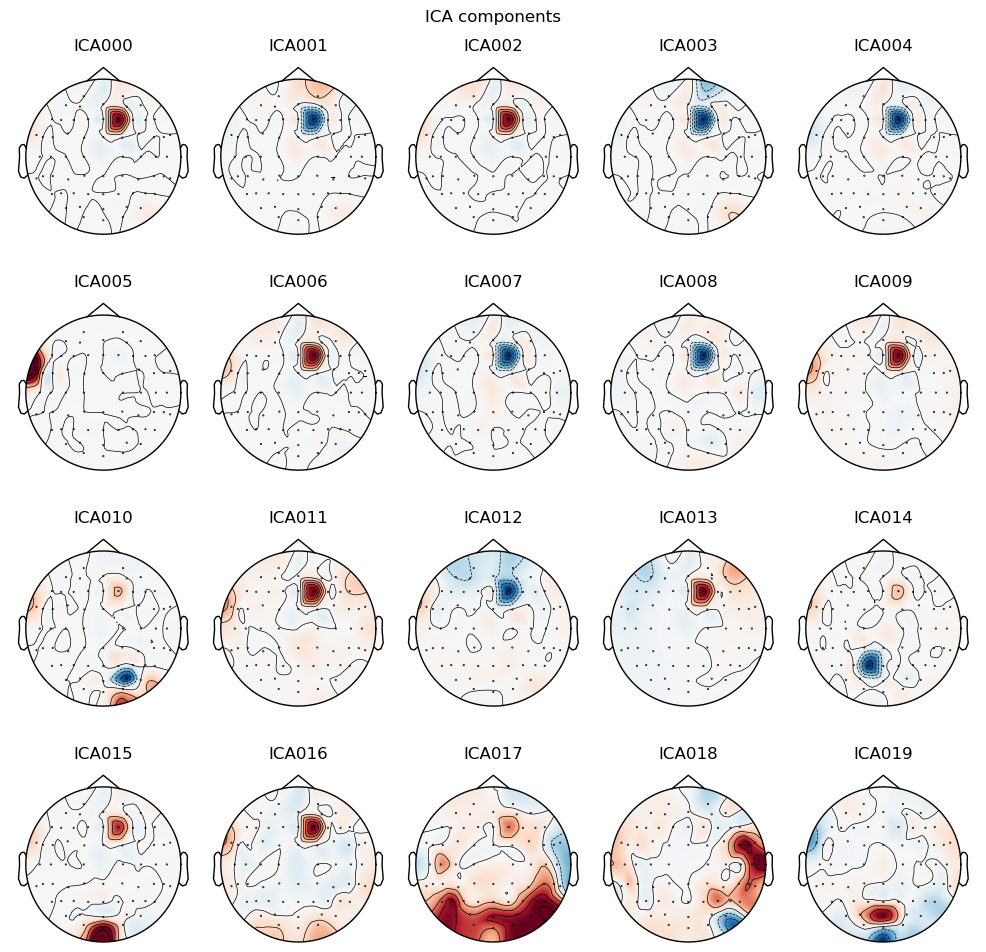

In [5]:
ica = mne.preprocessing.ICA(n_components=20, random_state=42)
ica.fit(raw_data.copy())
ic_plot = ica.plot_components()

In [ ]:
ica.exclude = [4, 6]
ica.plot_properties(raw_data, picks=ica.exclude)

In [ ]:
events, _ = mne.events_from_annotations(raw_data)
events_dict = {
    'blockonset': 1001,
    'blockend': 8,
    'fixation': 1,
    'delay1': 2,
    'delay2': 3,
    'response': 4,
    'feedback': 6,
    'iti': 7,
    'proinPF': 11,
    'prooutPF': 12,
    'antiinPF': 13,
    'antioutPF': 14
}
trl_events = {
    'proinPF': 11,
    'prooutPF': 12,
    'antiinPF': 13,
    'antioutPF': 14
}
#a = mne.viz.plot_events(events, first_samp=raw_data.first_samp, event_id=events_dict)

In [ ]:
rr = raw_data.plot(start=events[1, 0]/1000+1000, duration = 10, remove_dc=True)
rr = ica.apply(raw_data.copy(), exclude=ica.exclude).plot(start=events[1, 0]/1000+1000, duration = 10, remove_dc=False)

In [ ]:
epoched_data = mne.Epochs(
    raw_data, 
    events, 
    event_id=trl_events, 
    # tmin = -1.5,
    # tmax = 5.5,
    tmin=-1,
    tmax=4.5,
    baseline=None, 
    preload=True
)
epoched_data = ica.apply(epoched_data.copy(), exclude=ica.exclude)
b = epoched_data.plot()

In [ ]:
proinPF = epoched_data['proinPF']
prooutPF = epoched_data['prooutPF']
antiinPF = epoched_data['antiinPF']
antioutPF = epoched_data['antioutPF']
proinPF_evoked = proinPF.average()
prooutPF_evoked = prooutPF.average()
antiinPF_evoked = antiinPF.average()
antioutPF_evoked = antioutPF.average()

In [ ]:
prooutPF.plot_image(picks=["PO7", "PO8"])

In [ ]:
frequencies = np.linspace(3, 40, 20)
power = mne.time_frequency.tfr_morlet(
    proinPF, n_cycles=4, return_itc=False, freqs=frequencies, decim=3
)

aa = power.plot(["O1", "O2"])

In [ ]:
aa = mne.viz.plot_compare_evokeds(
    dict(pi=proinPF_evoked, po=prooutPF_evoked, ai=antiinPF_evoked, ao=antioutPF_evoked),
    legend="upper left",
    show_sensors="upper center"
)

In [ ]:
proinPF_evoked.plot_joint()